In [1]:
import pickle 
import os
import torch
import tqdm
import cv2 as cv
import numpy as np
import pandas as pd
from retinaface import RetinaFace
from dataclasses import dataclass
import albumentations as augs
from albumentations.pytorch.transforms import ToTensorV2
import torchvision
import torch.nn as nn
from transformers import TrainingArguments
from sklearn.metrics import accuracy_score, roc_curve
from datasets import load_metric
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import load_dataset, Image, Dataset, ClassLabel, concatenate_datasets
from transformers import (
    TrainingArguments, Trainer, ViTFeatureExtractor, ViTForImageClassification, 
    get_linear_schedule_with_warmup, AdamW)
import random

## Face Detection

In [1]:
# pip install retina-face

Note: you may need to restart the kernel to use updated packages.


In [155]:
resp = RetinaFace.detect_faces("data/team.jpg")

In [159]:
resp['face_1']

{'score': 0.9994702935218811,
 'facial_area': [178, 99, 242, 176],
 'landmarks': {'right_eye': [192.20178, 123.14015],
  'left_eye': [219.96054, 120.24275],
  'nose': [204.29753, 137.53477],
  'mouth_right': [196.72823, 155.39133],
  'mouth_left': [218.0741, 153.14351]}}

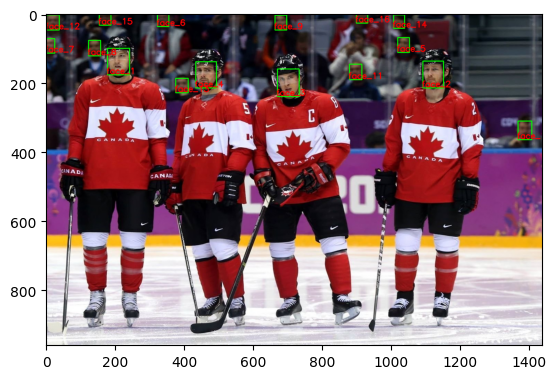

In [175]:
img = cv.imread("data/team.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB )
# Draw a rectangle around the face
for face in resp:
    y1, x1 = resp[face]['facial_area'][0], resp[face]['facial_area'][1]
    y2, x2 = resp[face]['facial_area'][2], resp[face]['facial_area'][3]
    cv.rectangle(img, (y1, x1), (y2, x2), (0, 255, 0), 2)
    cv.putText(img, face, (y1-3, x2-3), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
plt.imshow(img)

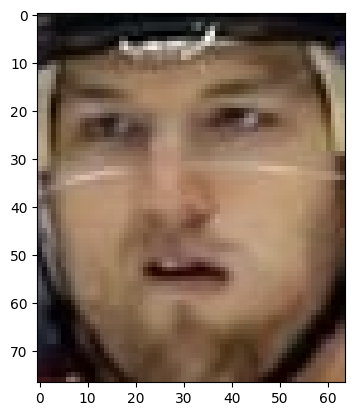

In [56]:
y1, x1 = resp['face_1']['facial_area'][0], resp['face_1']['facial_area'][1]
y2, x2 = resp['face_1']['facial_area'][2], resp['face_1']['facial_area'][3]
face = img[x1:x2, y1:y2]
plt.imshow(face)

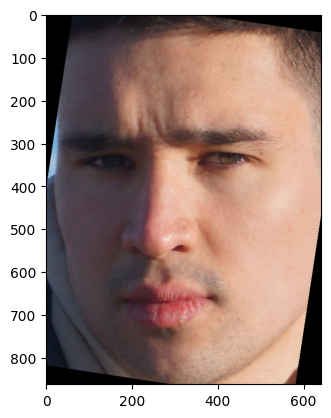

In [78]:
faces = RetinaFace.extract_faces(im, align = True)
i = 0
for face in faces:
    plt.imshow(face)
    plt.show()
    i += 1
    if i == 4:
        break

In [87]:
# Open the video file
video = cv.VideoCapture("data/horse.mp4")

# Check if the video file was opened successfully
if not video.isOpened():
    print("Error opening video file")
    
skip_interval = 5

# Initialize variables to store the frame with the highest score
max_score = 0
best_frame = None

# Read and process each frame
while True:
    # Read the next frame from the video
    ret, frame = video.read()

    # If the frame was not read successfully, the video has ended
    if not ret:
        break

    # Detect faces in the current frame
    faces = RetinaFace.detect_faces(frame)
    score = faces['face_1']['score']
    y1, x1, y2, x2 = faces['face_1']['facial_area']

    # Check if the current frame has a higher score than the previous best frame
    if score > max_score:
        max_score = score
        best_frame = frame.copy()
        y1_best, x1_best, y2_best, x2_best = y1, x1, y2, x2
        
    # Skip frames based on the specified interval
    for _ in range(skip_interval - 1):
        video.read()

# Release the video capture
video.release()

0.9996125102043152

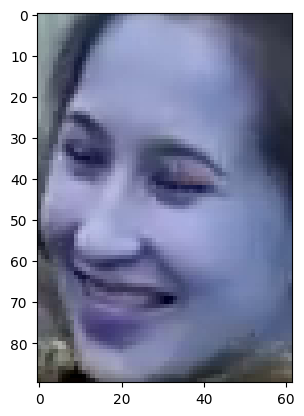

In [88]:
plt.imshow(best_frame[x1_best:x2_best, y1_best:y2_best])
max_score

## Age estimation

##### UTK_dataset

In [2]:
df = pd.read_csv('data/utkface.csv', header=None).rename({0:'image'}, axis=1)

def csv_preprocessing(x):
    df['age'] = df.loc[:, 'image'].apply(lambda x: float(x.split('_')[0]))
    df['gender'] = df.loc[:, 'image'].apply(lambda x: float(x.split('_')[1]))
    df['race'] = df.loc[:, 'image'].apply(lambda x: x.split('_')[2])
    df.loc[:, 'image'] = df.loc[:, 'image'].apply(lambda x: x.split(';')[0])
    df['path'] = df['image'].apply(lambda x: 'data/UTKFace_Dataset/' + x)
    return df

df = csv_preprocessing(df)
df

,image,age,gender,race,path
0,100_0_0_20170112213001988.jpg.chip.jpg,100.0,0.0,0,data/UTKFace_Dataset/100_0_0_20170112213001988...
1,100_0_0_20170112213500903.jpg.chip (2).jpg,100.0,0.0,0,data/UTKFace_Dataset/100_0_0_20170112213500903...
2,100_0_0_20170112213500903.jpg.chip (3).jpg,100.0,0.0,0,data/UTKFace_Dataset/100_0_0_20170112213500903...
3,100_0_0_20170112213500903.jpg.chip.jpg,100.0,0.0,0,data/UTKFace_Dataset/100_0_0_20170112213500903...
4,100_0_0_20170112215240346.jpg.chip.jpg,100.0,0.0,0,data/UTKFace_Dataset/100_0_0_20170112215240346...
...,...,...,...,...,...
23692,9_1_3_20161220222856346.jpg.chip.jpg,9.0,1.0,3,data/UTKFace_Dataset/9_1_3_20161220222856346.j...
23693,9_1_3_20170104222949455.jpg.chip.jpg,9.0,1.0,3,data/UTKFace_Dataset/9_1_3_20170104222949455.j...
23694,9_1_4_20170103200637399.jpg.chip.jpg,9.0,1.0,4,data/UTKFace_Dataset/9_1_4_20170103200637399.j...
23695,9_1_4_20170103200814791.jpg.chip.jpg,9.0,1.0,4,data/UTKFace_Dataset/9_1_4_20170103200814791.j...


In [3]:
# lets make files for a Dataset
utk_imgs = list(df['path'])
utk_labels = list(df['age'])
train_size = 17500
utk_train_imgs, utk_test_imgs = utk_imgs[:train_size], utk_imgs[train_size:]
utk_train_labels, utk_test_labels = utk_labels[:train_size], utk_labels[train_size:]

In [4]:
train_UTK_dataset = Dataset.from_dict({"image": utk_train_imgs, 'label':utk_train_labels}, split='train').cast_column("image", Image()).shuffle()
test_UTK_dataset = Dataset.from_dict({"image": utk_test_imgs, 'label':utk_test_labels}, split='test').cast_column("image", Image()).shuffle()

In [5]:
from datasets import Value
train_UTK_dataset = train_UTK_dataset.cast_column("label", Value("float32")).shuffle()
test_UTK_dataset = test_UTK_dataset.cast_column("label", Value("float32")).shuffle()

Casting the dataset:   0%|          | 0/17500 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6197 [00:00<?, ? examples/s]

In [6]:
train_UTK_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 17500
})

In [7]:
def transforms(examples):
    examples["image"] = [image.convert("RGB") for image in examples["image"]]
    return examples

train_UTK_dataset = train_UTK_dataset.map(transforms, batched=True)
test_UTK_dataset = test_UTK_dataset.map(transforms, batched=True)

Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

Map:   0%|          | 0/6197 [00:00<?, ? examples/s]

(200, 200, 3)
26.0


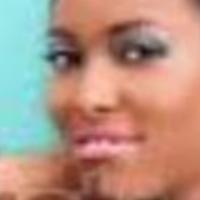

In [27]:
train_UTK_dataset[7]['image']

In [6]:
# Lets look at augmented UTK dataset 
df_aug = df.copy()
df_aug['image'] = df_aug['image'].apply(lambda x: 'aug_0_' + x)
folder_filenames = os.listdir('data/UTKFace_Dataset_augmented/')
filtered_train_df = df_aug[df_aug["image"].isin(folder_filenames)]
filtered_train_df['path'] = filtered_train_df['image'].apply(lambda x: 'data/UTKFace_Dataset_augmented/' + x)

# lets make files for a Dataset
utk_imgs_aug = list(filtered_train_df['path'])
utk_labels_aug = list(filtered_train_df['age'])

train_UTK_dataset_aug = Dataset.from_dict({"image": utk_imgs, 'label':utk_labels}, split='train').cast_column("image", Image()).shuffle()
train_UTK_dataset_aug = train_UTK_dataset_aug.cast_column("label", Value("float32")).shuffle()


Casting the dataset:   0%|          | 0/23697 [00:00<?, ? examples/s]

In [9]:
train_UTK_dataset_aug = train_UTK_dataset_aug.map(transforms, batched=True)

Map:   0%|          | 0/23697 [00:00<?, ? examples/s]

In [7]:
# lets merge augmented and ordinary datasets
assert train_UTK_dataset.features.type == train_UTK_dataset_aug.features.type
train_UTK_dataset = concatenate_datasets([train_UTK_dataset, train_UTK_dataset_aug]).shuffle()

##### Appa_dataset

In [8]:
# train df
df_valid = pd.read_csv('data/appa-real-release/gt_avg_valid.csv')
df_train = pd.read_csv('data/appa-real-release/gt_avg_train.csv')
df = pd.concat([df_train, df_valid], axis=0)

# test df
df_test = pd.read_csv('data/appa-real-release/gt_avg_test.csv')

folder_filenames = os.listdir('data/appa-real-release/cropped_images/')
filtered_train_df = df[df["file_name"].isin(folder_filenames)]
filtered_train_df['file_name'] = filtered_train_df['file_name'].apply(lambda x: 'data/appa-real-release/cropped_images/' + x)
filtered_train_df['real_age'] = filtered_train_df.loc[:, 'real_age'].apply(lambda x: float(x))

folder_filenames = os.listdir('data/appa-real-release/cropped_images_test/')
filtered_test_df = df_test[df_test["file_name"].isin(folder_filenames)]
filtered_test_df['file_name'] = filtered_test_df['file_name'].apply(lambda x: 'data/appa-real-release/cropped_images_test/' + x)
filtered_test_df['real_age'] = filtered_test_df.loc[:, 'real_age'].apply(lambda x: float(x))

In [9]:
# lets make files for a Dataset
appa_train_imgs = list(filtered_train_df['file_name'])
appa_train_labels = list(filtered_train_df['real_age'])

appa_test_imgs = list(filtered_test_df['file_name'])
appa_test_labels = list(filtered_test_df['real_age'])

In [10]:
train_appa_dataset = Dataset.from_dict({"image": appa_train_imgs, 'label':appa_train_labels}, split='train').cast_column("image", Image()).shuffle()
test_appa_dataset = Dataset.from_dict({"image": appa_test_imgs, 'label':appa_test_labels}, split='test').cast_column("image", Image()).shuffle()

In [11]:
from datasets import Value
train_appa_dataset = train_appa_dataset.cast_column("label", Value("float32")).shuffle()
test_appa_dataset = test_appa_dataset.cast_column("label", Value("float32")).shuffle()

Casting the dataset:   0%|          | 0/5596 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1974 [00:00<?, ? examples/s]

In [12]:
# Lets consider augmented dataset
df_aug = df.copy()
df_aug['file_name'] = df['file_name'].apply(lambda x: 'aug_0_' + x)
df_aug['real_age'] = df_aug.loc[:, 'real_age'].apply(lambda x: float(x))
folder_filenames = os.listdir('data/appa-real-release/augmented_imgs/')
df_aug = df_aug[df_aug["file_name"].isin(folder_filenames)]
df_aug['file_name'] = df_aug['file_name'].apply(lambda x: 'data/appa-real-release/augmented_imgs/' + x)
appa_train_imgs_aug = list(df_aug['file_name'])
appa_train_labels_aug = list(df_aug['real_age'])

train_appa_dataset_aug = Dataset.from_dict({"image": appa_train_imgs_aug, 'label':appa_train_labels_aug}, split='train').cast_column("image", Image()).shuffle()
train_appa_dataset_aug = train_appa_dataset_aug.cast_column("label", Value("float32")).shuffle()

Casting the dataset:   0%|          | 0/5596 [00:00<?, ? examples/s]

#### concatenation of the datasets

In [13]:
assert train_UTK_dataset.features.type == train_appa_dataset.features.type
assert train_UTK_dataset.features.type == train_appa_dataset_aug.features.type
merged_train_dataset = concatenate_datasets([train_UTK_dataset, train_appa_dataset]).shuffle()
merged_train_dataset = concatenate_datasets([merged_train_dataset, train_appa_dataset_aug]).shuffle()
merged_test_dataset = concatenate_datasets([test_UTK_dataset, test_appa_dataset]).shuffle()

### ViT

In [14]:
model_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)
model = ViTForImageClassification.from_pretrained(model_id, num_labels=1, problem_type = "regression")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
from transformers import MobileViTFeatureExtractor, MobileViTForImageClassification

In [83]:
feature_extractor = MobileViTFeatureExtractor.from_pretrained("apple/mobilevit-small")
model = MobileViTForImageClassification.from_pretrained("apple/mobilevit-small", ignore_mismatched_sizes=True, num_labels=1, problem_type = "regression")

Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([1, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['label'] = batch['label']
    return inputs

In [16]:
# transform the training dataset
prepared_train = merged_train_dataset.with_transform(preprocess)
# ... and the testing dataset
prepared_test = merged_test_dataset.with_transform(preprocess)

In [17]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [19]:
class RMSELoss(nn.Module):
    """
    Code taken from Y Nakama's notebook (https://www.kaggle.com/code/yasufuminakama/fb3-deberta-v3-base-baseline-train)
    """
    def __init__(self, reduction='mean', eps=1e-9):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.reduction = reduction
        self.eps = eps

    def forward(self, predictions, targets):
        loss = torch.sqrt(self.mse(predictions, targets) + self.eps)
        if self.reduction == 'none':
            loss = loss
        elif self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()
        return loss

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        loss_func = RMSELoss(reduction='mean')
        loss = loss_func(outputs.logits.float(), inputs['labels'].float())
        return (loss, outputs) if return_outputs else loss

def compute_metrics_RMSE(eval_pred):
    predictions, labels = eval_pred
    colwise_rmse = np.sqrt((labels - predictions) ** 2)
    res = np.mean(np.array(colwise_rmse), axis=1)
    return {'RMSE': np.mean(res)}

In [20]:
epochs = 4
train_batch_size = 12
n_accumulate = 1
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.weight"]


training_args = TrainingArguments(
    output_dir="./ViT_ordinary",
    per_device_train_batch_size=train_batch_size,
    evaluation_strategy="steps",
    num_train_epochs=epochs,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=1e-6,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45.0


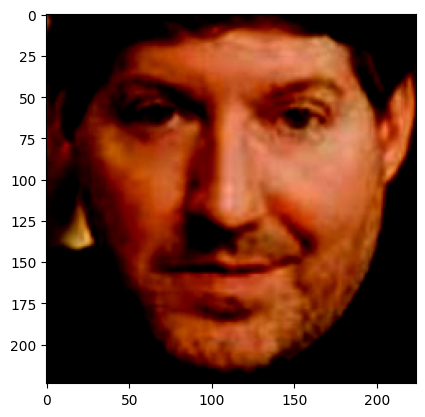

In [77]:
i=2001
print(prepared_train[i]['label'])
plt.imshow(prepared_train[i]['pixel_values'].permute(1,2,0))

In [21]:
optimizer_parameters = [
    {
        "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        "weight_decay": 1e-6,
    },
    {
        "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
optimizer = AdamW(optimizer_parameters, lr=2e-4)
num_training_steps = (len(prepared_train) * epochs) // (train_batch_size * n_accumulate)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0.1*num_training_steps,
    num_training_steps=num_training_steps
)
custom_trainer = False
if custom_trainer:
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics_RMSE,
        train_dataset=prepared_train,
        eval_dataset=prepared_test,
        tokenizer=feature_extractor,
        optimizers=(optimizer, scheduler),
    )
else:
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics_RMSE,
        train_dataset=prepared_train,
        eval_dataset=prepared_test,
        tokenizer=feature_extractor,
        optimizers=(optimizer, scheduler),
    )
    
trainer.train()

Step,Training Loss,Validation Loss,Rmse
100,1138.514400,2676.440674,45.473885
200,940.419100,2574.700928,44.358047
300,921.675300,2526.614502,43.825012
400,938.659200,2458.261719,43.110458
500,904.052000,2360.754395,42.121014
600,852.848000,2225.541504,40.799175
700,685.997900,2045.955322,39.182892
800,612.646100,1821.157959,37.148788
900,487.538400,1558.366211,34.589008
1000,363.136700,1274.243164,31.560568


during compute_metrics_RMSE
[45.6456   45.349564 45.534847 ... 45.484585 45.446728 45.334476]
(8171, 8171)
during compute_metrics_RMSE
[44.362484 44.34012  44.361244 ... 44.355503 44.35015  44.346874]
(8171, 8171)
during compute_metrics_RMSE
[43.825886 43.820034 43.825962 ... 43.823906 43.82402  43.822132]
(8171, 8171)
during compute_metrics_RMSE
[43.11051  43.107506 43.110794 ... 43.11004  43.110172 43.109035]
(8171, 8171)
during compute_metrics_RMSE
[42.12087  42.119457 42.12109  ... 42.120518 42.12051  42.1202  ]
(8171, 8171)
during compute_metrics_RMSE
[40.799313 40.798294 40.79875  ... 40.79906  40.798855 40.79855 ]
(8171, 8171)
during compute_metrics_RMSE
[39.18288  39.182327 39.182728 ... 39.18269  39.18242  39.182507]
(8171, 8171)
during compute_metrics_RMSE
[37.148777 37.148346 37.148777 ... 37.148594 37.14839  37.148514]
(8171, 8171)
during compute_metrics_RMSE
[34.588852 34.588776 34.588676 ... 34.58868  34.588806 34.588535]
(8171, 8171)
during compute_metrics_RMSE
[31.55995

KeyboardInterrupt: 

In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

### Inference if ViT

In [144]:
from PIL import Image
import torch.nn.functional as F


class OpenEyesClassificator():
    def __init__(self, model_path):
        self.model = ViTForImageClassification.from_pretrained(model_path)
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_path)
    
    def predict(self, inpIm):
        # img = Image.open(inpIm).convert('RGB')
        img_features = self.feature_extractor(inpIm, return_tensors="pt")
        with torch.no_grad():
            logits = self.model(**img_features).logits
        # softmax_scores = F.softmax(logits, dim=1)
        return logits #softmax_scores[0, 1].item()

In [145]:
classificator = OpenEyesClassificator('ViT_ordinary/checkpoint-2500/')

In [164]:
classificator = OpenEyesClassificator('Batr97/ViT_ordinary')

In [165]:
im = cv.imread(filtered_train_df.iloc[110,0])
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
im = Image.fromarray(im)
# plt.imshow(im)
filtered_train_df.iloc[110,0]

'data/appa-real-release/cropped_images/000112.jpg'

In [166]:
classificator.predict(im)
# classificator.predict('data/appa-real-release/cropped_images/000112.jpg')

tensor([[52.5334]])

In [97]:
%load_ext autoreload
%autoreload 2

In [119]:
from io import BytesIO
import cv2

with open('data/horse.mp4', "rb") as f:
    video_bytes = f.read()

# Create a BytesIO object from `video_bytes`
video_bytes_io = BytesIO(video_bytes)

cv2.VideoCapture(video_bytes_io)


error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'VideoCapture'
> Overload resolution failed:
>  - Can't convert object to 'str' for 'filename'
>  - VideoCapture() missing required argument 'apiPreference' (pos 2)
>  - Argument 'index' is required to be an integer
>  - VideoCapture() missing required argument 'apiPreference' (pos 2)


In [32]:
classificator.predict(filtered_train_df.iloc[10, 0])

tensor([[16.6478]])

In [157]:
trainer.push_to_hub()

OSError: Looks like you do not have git-lfs installed, please install. You can install from https://git-lfs.github.com/. Then run `git lfs install` (you only have to do this once).

In [158]:
from huggingface_hub import login
login()

In [162]:
from huggingface_hub import HfApi
api = HfApi()
# api.upload_file(
#     path_or_fileobj="ViT_ordinary/checkpoint-2500",
#     path_in_repo="weights/",
#     repo_id="Batr97/ViT_ordinary",
#     repo_type="model",
# )
api.upload_folder(
    folder_path="ViT_ordinary/checkpoint-2500",
    repo_id="Batr97/ViT_ordinary",
    repo_type="model",
    create_pr=1
)

'https://huggingface.co/Batr97/ViT_ordinary/tree/refs%2Fpr%2F1/'